# Implementation of pixel-flipping algorithm

In [2]:
import numpy
import torch
from torchvision import transforms

from lrp import image

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../data/castle2.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
print(X.shape)

torch.Size([1, 3, 224, 224])


In [8]:
# https://discuss.pytorch.org/t/how-to-extract-smaller-image-patches-3d/16837/4

S = 3 # channel dim
W = 224 # width
H = 224 # height
batch_size = 1

x = torch.randn(batch_size, S, W, H)
print(x.shape)

# kernel size
size = 8 # patch size
stride = 8 # patch stride
patches = x.unfold(0, 3, 3)
print('1', patches.shape)
patches = patches.unfold(1, size, stride)
print('2', patches.shape)
patches = patches.unfold(2, size, stride)
print('3', patches.shape)
# patches = x.unfold(1, size, stride).unfold(2, size, stride).unfold(3, size, stride)
print('123', patches.size())

torch.Size([1, 3, 224, 224])


RuntimeError: maximum size for tensor at dimension 0 is 1 but size is 3

In [37]:
# https://discuss.pytorch.org/t/how-to-extract-smaller-image-patches-3d/16837/4

S = 128 # channel dim
W = 256 # width
H = 256 # height
batch_size = 1

x = torch.randn(batch_size, S, W, H)
print(x.shape)

size = 64 # patch size
stride = 64 # patch stride
patches = x.unfold(1, size, stride).unfold(2, size, stride).unfold(3, size, stride)
print(patches.shape)

torch.Size([1, 128, 256, 256])
torch.Size([1, 2, 4, 4, 64, 64, 64])


In [22]:
import torch
import torch.nn.functional as F

# https://github.com/pytorch/pytorch/pull/1523
# https://discuss.pytorch.org/t/how-to-extract-smaller-image-patches-3d/16837

batch_size = 128
channels = 16
height, width = 32, 32
x = torch.randn(batch_size, channels, height, width)
print('x', x.shape)

# Kernel size
kh, kw = 3, 3
# Stride
dh, dw = 1, 1

# Pad tensor to get the same output
x = F.pad(x, (1, 1, 1, 1))

# get all image windows of size (kh, kw) and stride (dh, dw)
patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
print(patches.shape)  # [128, 16, 32, 32, 3, 3]
# Permute so that channels are next to patch dimension
patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # [128, 32, 32, 16, 3, 3]
# View as [batch_size, height, width, channels*kh*kw]
patches = patches.view(*patches.size()[:3], -1)
print(patches.shape)
# > torch.Size([128, 32, 32, 144])

x torch.Size([128, 16, 32, 32])
torch.Size([128, 16, 32, 32, 3, 3])
torch.Size([128, 32, 32, 144])


TypeError: Invalid shape (256, 256, 128) for image data

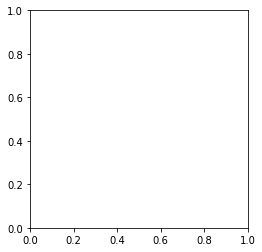

In [41]:
import matplotlib.pyplot as plt

# PyTorch modules processing image data expect tensors in the format C × H × W.1
# Whereas PILLow and Matplotlib expect image arrays in the format H × W × C.2
# Source: https://stackoverflow.com/a/66641911
plt.imshow(x[0].numpy().transpose((1, 2, 0)))

for patch in patches:
  plt.imshow(patch.numpy()[0], cmap='gray')
  break

In [33]:
import math

import torch.nn.functional as F

# https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837/10

def extract_image_patches(x, kernel, stride=1, dilation=1):
    # Do TF 'SAME' Padding
    b,c,h,w = x.shape

    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = F.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))
    
    # Extract patches
    patches = x.unfold(2, kernel, stride).unfold(3, kernel, stride)
    patches = patches.permute(0,4,5,1,2,3).contiguous()
    
    return patches.view(b,-1,patches.shape[-2], patches.shape[-1])

In [35]:
patches = extract_image_patches(X, 2, stride=2, dilation=1)
print(patches.shape)

RuntimeError: shape '[1, 3, 112, 112]' is invalid for input of size 150528

In [81]:
import matplotlib.pyplot as plt

print(patches.shape)
print(patches.permute(0,4,1,2,3).shape)
for patch in patches.permute(0,4,1,2,3):
  print(patch.shape)
  plt.imshow(patch.numpy().transpose((1, 2, 0)))

torch.Size([1, 3, 223, 223, 4])
torch.Size([1, 4, 3, 223, 223])
torch.Size([4, 3, 223, 223])


ValueError: axes don't match array

In [58]:
# https://github.com/pytorch/pytorch/pull/1523#issue-227526015

def max_pool2d(input, kernel_size, stride):
    kh, kw = kernel_size
    dh, dw = stride
    # get all image windows of size (kh, kw) and stride (dh, dw)
    input_windows = input.unfold(2, kh, dh).unfold(3, kw, dw)
    print(input_windows.shape)
    # view the windows as (kh * kw)
    input_windows = input_windows.contiguous().view(*input_windows.size()[:-2], -1)
    print(input_windows.shape)
    max_val, max_idx = input_windows.max(4)
    return input_windows, max_val, max_idx

patches, max_val, max_idx = max_pool2d(X, (2,2), (2,2))
print(patches.shape)
# print(max_val.shape)
# print(max_idx.shape)

torch.Size([1, 3, 223, 223, 2, 2])
torch.Size([1, 3, 223, 223, 4])
torch.Size([1, 3, 223, 223, 4])


In [32]:
# import torch.nn.functional as F
# x_half = F.max_pool3d(Variable(x), kernel_size=2, stride=2)

SyntaxError: invalid syntax (3692450390.py, line 2)